# Trabalho 1 - Classificação: Sistema de Apoio à Decisão p/ Aprovação de Crédito


In [130]:
#=====================================================================
# Universidade Federal do Rio de Janeiro
# Escola Politecnica
# Departamento de Eletronica e de Computacao
# EEL891 -Introdução a Aprendizagem de Maquina - Turma 2025-2
# Prof. Heraldo
# Autor: Felipe Vasconcellos Nunes Gurgel Farias
#=====================================================================

# 1 - Imports principais

In [131]:
# ==========================================================
# - Importar bibliotecas essenciais para leitura de dados,
#   pré-processamento, treinamento e avaliação
# ==========================================================

!pip install xgboost --quiet

import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# 2 - Upload e Carregamento dos Arquivos de Dados

In [132]:
# ==========================================================
# - Ler os datasets de treino e teste fornecidos no trabalho
# - Carregar o dicionário de dados (para identificar tipos)
# - Carregar o exemplo de submissão (para garantir formato)
# ==========================================================

uploaded = files.upload()

#Verifica os arquivos importados
print("\nArquivos disponíveis no ambiente:")
for f in os.listdir():
    print(" -", f)

caminho_treinamento = "conjunto_de_treinamento.csv"
caminho_teste       = "conjunto_de_teste.csv"
caminho_respostas   = "exemplo_arquivo_respostas.csv"
caminho_dicionario  = "dicionario_de_dados.xlsx"

train_data = pd.read_csv(caminho_treinamento)
test_data  = pd.read_csv(caminho_teste)
exemplo_resposta = pd.read_csv(caminho_respostas)
dicionario = pd.read_excel(caminho_dicionario)

print("\nDados carregados com sucesso!")
print("\nTreino:", train_data.shape, "| Teste:", test_data.shape)
display(train_data.head())

Saving conjunto_de_teste.csv to conjunto_de_teste (6).csv
Saving conjunto_de_treinamento.csv to conjunto_de_treinamento (6).csv
Saving dicionario_de_dados.xlsx to dicionario_de_dados (6).xlsx
Saving exemplo_arquivo_respostas.csv to exemplo_arquivo_respostas (6).csv

Arquivos disponíveis no ambiente:
 - .config
 - conjunto_de_teste (4).csv
 - conjunto_de_treinamento (4).csv
 - exemplo_arquivo_respostas (2).csv
 - conjunto_de_teste.csv
 - conjunto_de_treinamento (5).csv
 - exemplo_arquivo_respostas (3).csv
 - dicionario_de_dados (5).xlsx
 - conjunto_de_teste (2).csv
 - conjunto_de_teste (3).csv
 - dicionario_de_dados (1).xlsx
 - exemplo_arquivo_respostas (4).csv
 - exemplo_arquivo_respostas (6).csv
 - dicionario_de_dados.xlsx
 - conjunto_de_treinamento (2).csv
 - conjunto_de_treinamento.csv
 - conjunto_de_teste (6).csv
 - submission.csv
 - conjunto_de_teste (1).csv
 - catboost_info
 - conjunto_de_teste (5).csv
 - exemplo_arquivo_respostas (5).csv
 - conjunto_de_treinamento (6).csv
 - exe

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,...,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,...,N,,0,9.0,1.0,0.0,0.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,0,...,N,,0,2.0,5.0,NaN,NaN,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,0,...,N,,0,NaN,NaN,NaN,NaN,450.0,450.0,1
3,4,1,20,internet,1,M,37,1,1,0,...,Y,54,0,9.0,2.0,NaN,NaN,932.0,932.0,1
4,5,7,1,internet,1,F,51,1,3,0,...,N,,0,9.0,5.0,NaN,NaN,440.0,440.0,1


# 3 - Identificar variáveis numéricas e categóricas

In [133]:
# ===================================================================================
# - Usar o dicionário de dados para separar variáveis categóricas e numéricas
#   de forma automatizada (baseada em metadados).
# - Evitar hardcode/manual, aumentando reprodutibilidade do experimento.
# - Preparar listas de colunas para o pré-processamento (Pipeline/ColumnTransformer).
# - Mesmo que o dicionário classifique "id_solicitante" como numérico,
#   ele é um IDENTIFICADOR e não deve ser usado como variável preditiva,
#   pois pode induzir overfitting e padrões artificiais.
# ====================================================================================

# Variáveis categóricas: detectadas pela descrição no dicionário
categorical_vars = dicionario[
    dicionario["Descrição"].str.contains("código|categoria|forma|sexo|estado", case=False, na=False)
]["Nome da Variável"].tolist()

# Variáveis numéricas: detectadas pela descrição no dicionário
numerical_vars = dicionario[
    dicionario["Descrição"].str.contains("valor|número|idade|renda|meses", case=False, na=False)
]["Nome da Variável"].tolist()

# Garantir que as variáveis existem no dataset (evita colunas inexistentes)
categorical_vars = [c for c in categorical_vars if c in train_data.columns]
numerical_vars   = [c for c in numerical_vars   if c in train_data.columns]

# Remoção explícita de identificadores (não são features preditivas)
# Justificativa: identificadores não carregam informação do fenômeno e podem causar overfitting.
drop_ids = ["id_solicitante"]
categorical_vars = [c for c in categorical_vars if c not in drop_ids]
numerical_vars   = [c for c in numerical_vars   if c not in drop_ids]

# Diagnóstico rápido (útil para conferência e relatório)
print("Número de variáveis categóricas:", len(categorical_vars))
print("Número de variáveis numéricas:", len(numerical_vars))
print("Exemplo categóricas:", categorical_vars[:10])
print("Exemplo numéricas:", numerical_vars[:10])





Número de variáveis categóricas: 15
Número de variáveis numéricas: 10
Exemplo categóricas: ['forma_envio_solicitacao', 'tipo_endereco', 'sexo', 'estado_civil', 'qtde_dependentes', 'estado_onde_nasceu', 'estado_onde_reside', 'codigo_area_telefone_residencial', 'meses_na_residencia', 'vinculo_formal_com_empresa']
Exemplo numéricas: ['idade', 'qtde_dependentes', 'nacionalidade', 'meses_na_residencia', 'renda_mensal_regular', 'renda_extra', 'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais', 'valor_patrimonio_pessoal', 'meses_no_trabalho']


#4 - Análise Exploratória dos Dados (EDA)

In [134]:
# ============================================================================
# - Compreender a distribuição da variável-alvo (inadimplência)
# - Avaliar possíveis relações lineares entre variáveis numéricas
# - Identificar indícios de multicolinearidade
# - Justificar a escolha de modelos não lineares na etapa de modelagem
#
# Obs:
# - Toda a análise exploratória é realizada APENAS sobre o conjunto
#   de treinamento, evitando qualquer vazamento de informação (data leakage)
# ============================================================================

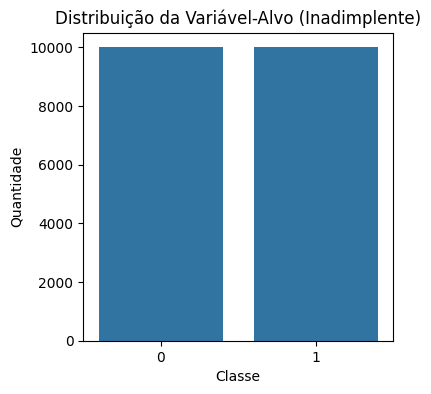

In [135]:
X = train_data.drop(columns=["inadimplente"])
y = train_data["inadimplente"]

# Verifica a Distribuição da variável-alvo
# A análise permite verificar possíveis desbalanceamentos, orientando a escolha da métrica de avaliação.
plt.figure(figsize=(4,4))
sns.countplot(x=y)
plt.title("Distribuição da Variável-Alvo (Inadimplente)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.show()

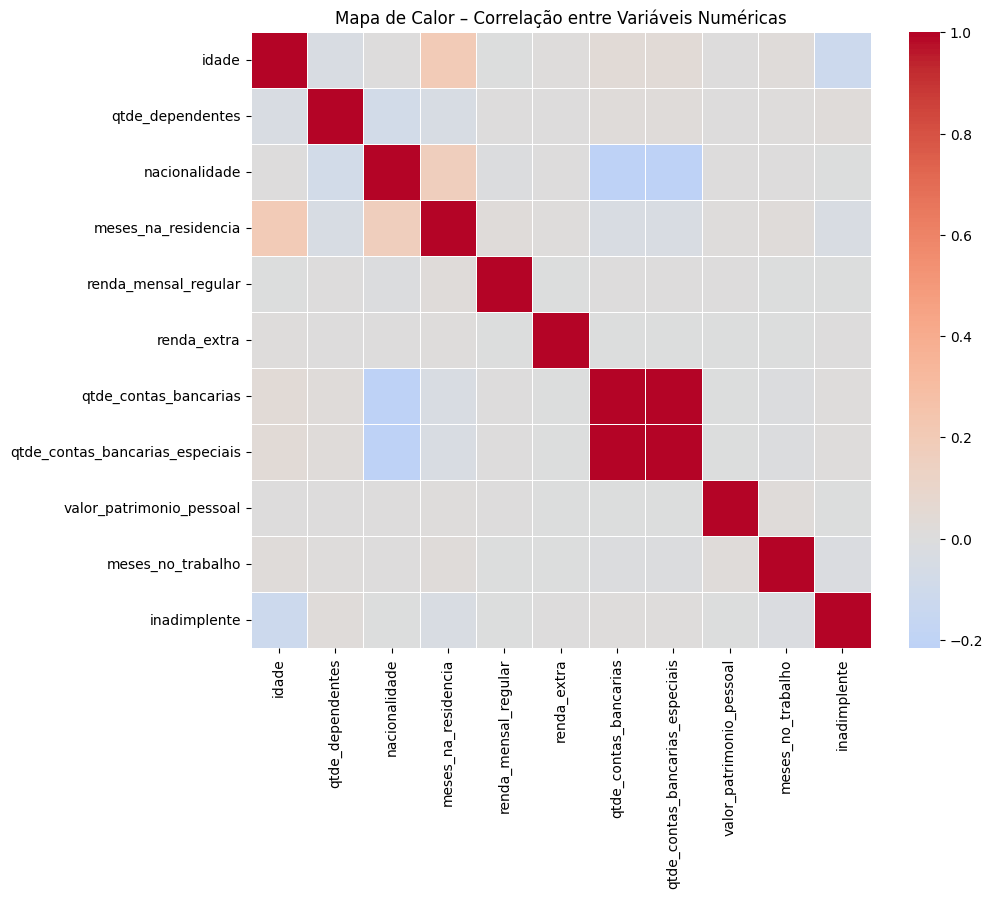

In [136]:
# ============================================================
# Mapa de calor das correlações entre variáveis numéricas.
# Permite identificar relações lineares fortes e possíveis.
# problemas de multicolinearidade.
# ============================================================

# Correlação apenas com variáveis numéricas
corr_df = train_data[numerical_vars + ["inadimplente"]]
corr = corr_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Mapa de Calor – Correlação entre Variáveis Numéricas")
plt.show()

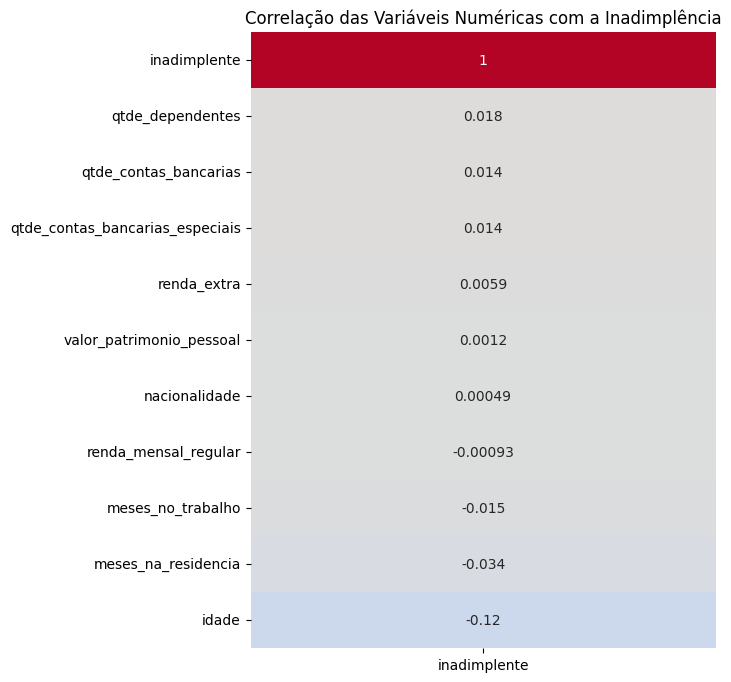

In [137]:
# =====================================================================================================================================
# Correlação das variáveis numéricas com a variável-alvo.
# Valores próximos de zero indicam baixa relação linear, sugerindo a necessidade de modelos capazes de capturar relações não lineares.
# ======================================================================================================================================

corr_target = corr["inadimplente"].sort_values(ascending=False)

plt.figure(figsize=(6,8))
sns.heatmap(
    corr_target.to_frame(),
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar=False
)
plt.title("Correlação das Variáveis Numéricas com a Inadimplência")
plt.show()

# 5 - Pré-processamento dos Dados (Pipeline)

In [138]:
# ====================================================================
# - Tratar valores ausentes (imputação) para evitar perda de dados
# - Padronizar variáveis numéricas (StandardScaler) para estabilidade
# - Codificar variáveis categóricas (One-Hot) para uso em modelos
# Justificativa:
# - Modelos lineares se beneficiam de escala
# - One-Hot permite representar categorias sem impor ordem artificial
# - "handle_unknown=ignore" evita erro com categorias novas no teste
# ====================================================================

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, numerical_vars),
        ("cat", categorical_transformer, categorical_vars)
    ],
    remainder="drop"
)



# 6 - Separação de Dados e Split Treino/Validação

In [139]:
# ============================================================
# - Separar variáveis explicativas (X) e variável-alvo (y)
# - Remover identificadores que não carregam informação preditiva real
# - Criar conjunto de validação para avaliar generalização
# - Usar stratify=y para manter proporção das classes
# ============================================================

X = train_data.drop(columns=["inadimplente"])
y = train_data["inadimplente"]

# Remover identificador do conjunto de variáveis explicativas:
# - "id_solicitante" é um identificador (não representa característica do cliente)
# - Pode induzir padrões artificiais e piorar a generalização (overfitting)
if "id_solicitante" in X.columns:
    X = X.drop(columns=["id_solicitante"])

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("Distribuição y (treino):", y_train.value_counts(normalize=True).round(4).to_dict())
print("Distribuição y (val):", y_val.value_counts(normalize=True).round(4).to_dict())

X_train: (16000, 40) X_val: (4000, 40)
Distribuição y (treino): {1: 0.5, 0: 0.5}
Distribuição y (val): {1: 0.5, 0: 0.5}


# 7 - Modelos

In [140]:
# ============================================================================================
# - Comparar três famílias de classificadores:
#   (I)   Linear (Logistic Regression) -> baseline interpretável
#   (II)  Árvores em conjunto (Random Forest) -> não linear e robusto
#   (III) Boosting (XGBoost) -> Eficaz na captura de relações não lineares em dados tabulares
# Obs:
# - Todos os modelos usam o MESMO preprocessor, garantindo comparação justa
# ============================================================================================

# Regressão Logística (baseline)
log_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=900, C=0.7))
])

# Random Forest
rf_model = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=600,
        max_depth=20,
        min_samples_split=3,
        min_samples_leaf=2,
        random_state=42
    ))
])

# XGBoost (modelo final do código-base)
xgb_model = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=700,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=6,
        gamma=0.4,
        reg_alpha=0.8,
        reg_lambda=2.0,
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

modelos = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

# 8 - Treinamento e Validação (Hold-out)

In [141]:
# ==============================================================
# - Treinar modelos no conjunto de treino
# - Avaliar no conjunto de validação
# - Usar classification_report para analisar precision/recall/f1
# ==============================================================

for nome, modelo in modelos.items():
    print(f"\nTreinando o [Modelo {nome}]...")
    print("\nRelatório:")

    modelo.fit(X_train, y_train)
    preds = modelo.predict(X_val)

    print(classification_report(y_val, preds))


Treinando o [Modelo Logistic Regression]...

Relatório:
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      2000
           1       0.58      0.59      0.59      2000

    accuracy                           0.58      4000
   macro avg       0.58      0.58      0.58      4000
weighted avg       0.58      0.58      0.58      4000


Treinando o [Modelo Random Forest]...

Relatório:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56      2000
           1       0.58      0.64      0.61      2000

    accuracy                           0.59      4000
   macro avg       0.59      0.59      0.59      4000
weighted avg       0.59      0.59      0.59      4000


Treinando o [Modelo XGBoost]...

Relatório:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      2000
           1       0.58      0.60      0.59      2000

    accuracy                 

#9 - Treino Final + Geração do Arquivo p/ Kaggle

In [142]:
# ====================================================================================
# - Treinar o modelo escolhido com TODO o conjunto de treino (maximiza uso de dados)
# - Gerar o arquivo submission.csv no formato exigido:
#   (id_solicitante + inadimplente)
# - Garantir que o conjunto de teste possua exatamente as mesmas colunas de X
#   (mesma ordem e sem colunas extras)
# - Remover "id_solicitante" do conjunto de teste, pois é apenas um identificador
# ====================================================================================

best_model = xgb_model
best_model.fit(X, y)

# 1) Preparar X_test com as MESMAS colunas usadas no treino
# (regras: mesma lista de colunas e mesma ordem)
X_test = test_data.copy()

# Remove o identificador do conjunto de teste (não é feature)
X_test = X_test.drop(columns=["id_solicitante"], errors="ignore")

# Garante que X_test tenha exatamente as colunas de X (mesmo conjunto e ordem)
X_test = X_test[X.columns]

# 2) Predição final
final_preds = best_model.predict(X_test)

# 3) Montar arquivo de submissão
submission = pd.DataFrame({
    "id_solicitante": test_data["id_solicitante"],
    "inadimplente": final_preds
})

submission.to_csv("submission.csv", index=False)

print("Arquivo 'submission.csv' gerado!")
display(submission.head())

files.download("submission.csv")
print("\nArquivo 'submission.csv' encaminhado para download!")


Arquivo 'submission.csv' gerado!


,id_solicitante,inadimplente
0,20001,1
1,20002,1
2,20003,1
3,20004,0
4,20005,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Arquivo 'submission.csv' encaminhado para download!
